# Proposed pipeline

This file contains:

  - UNext, ULite and MiniULite training
  - Pipeline for using MiniULite as an RPN and Attention U-Net as a robust model for segmentation
  - Exports to ONNX format
  - Benchmark tests on GPU and CPU
  - Count of trainable parameters and GFLOPS

Obs: Attention U-Net training is not present in this file, as it was carried out in Google COLAB

## Common loading

In [1]:
import config
import torch
import sys
sys.path.append('../util')
# path to https://github.com/LeeJunHyun/Image_Segmentation/ cloned repository
sys.path.append('../others_networks/')
sys.path.append('/media/calculon/TUDAO/Image_Segmentation')

import time
from Trainer import *
from util import measure_inference_speed
from DatasetReader import *
from ImageComparisonGenerator import ImageComparisonGenerator, load_model
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
result_path       = './trained_models/'
colab_result_path = './trained_models_on_colab/'

In [2]:
dataset_path        = "/home/calculon/0Datasets/fuseg/augmented-v3-512/"
full_resolution     = 512
out_channels        = config.num_classes
in_channels         = config.in_channels

In [3]:
train_loader, test_loader, val_loader = get_datasets(dataset_dir=dataset_path, 
                                              resolution=full_resolution, 
                                              batch_size=config.batch_size)

torch.Size([16, 3, 512, 512]) torch.Size([16, 1, 512, 512])


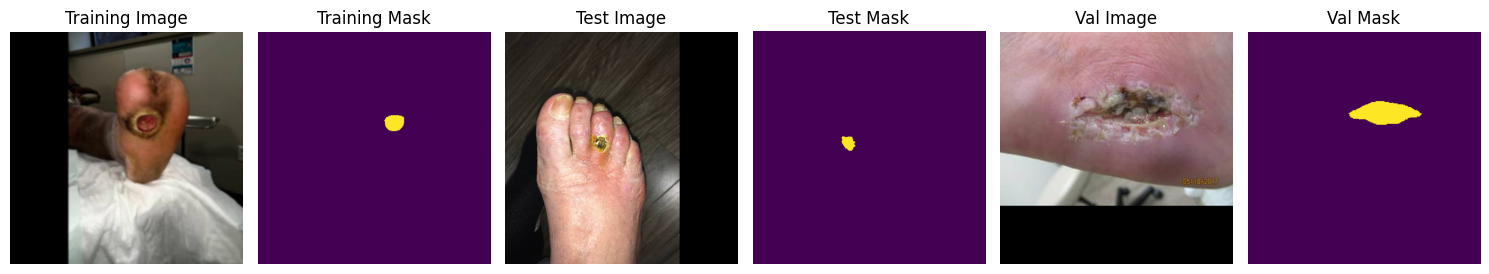

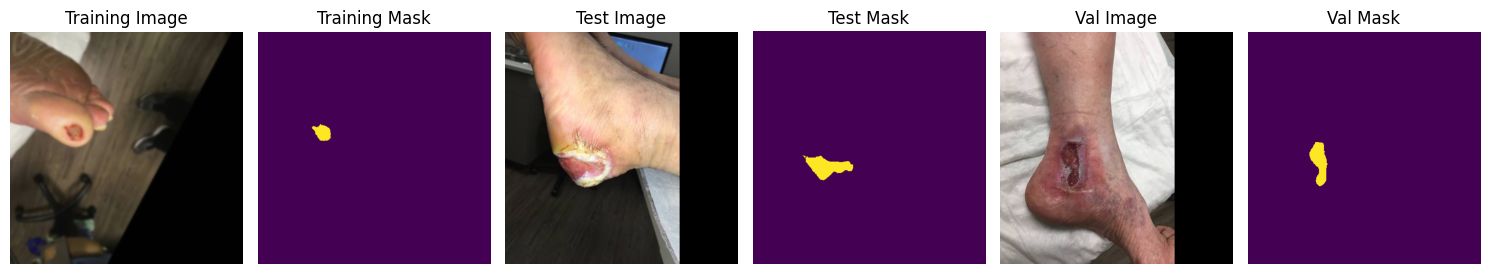

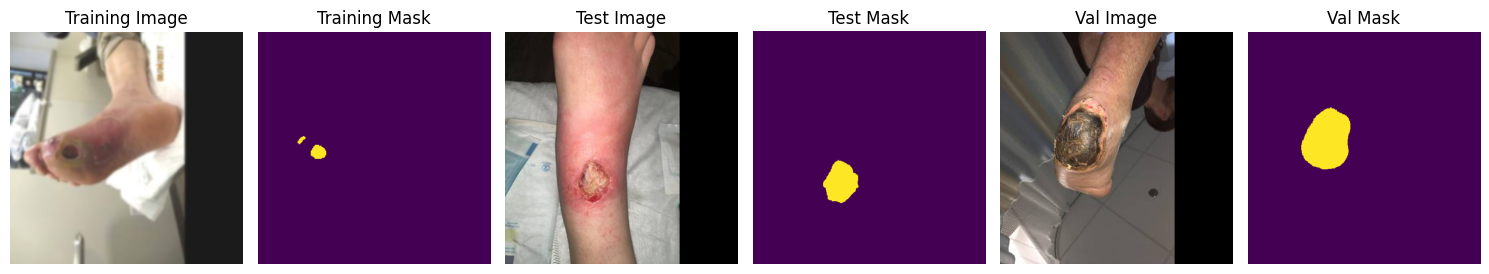

In [4]:
for (images_train, masks_train), (images_test, masks_test) in zip(train_loader, test_loader):
    print(images_train.shape, masks_train.shape)
    break

show_dataset_prev(train_loader, test_loader, val_loader, num_images=3)
#See if the samples are coherent with the dataset as well as the resolution

### Training functions

In [5]:
#train functions
import torch.nn.functional as F
import torch.nn as nn
from enum import Enum

class PipelineLosses(Enum):
    BCEDiceLoss                = 0
    WBCE                       = 1 #WeightedBinaryCrossEntropy
    FocalLoss                  = 2
    AsymmetricLoss             = 3


# Training with Focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        """
        alpha > 0.5 gives more weight to the positive class (favors recall)
        gamma controls focus in difficult examples
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Standard ECB
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        # convert to probability
        pt = torch.exp(-bce_loss)
        # applies the focal factor
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return loss.mean()


# Training with Asymmetric Loss
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_pos=0, gamma_neg=4):
        """
        gamma_neg > gamma_pos reduces penalties for false positives
        """
        super().__init__()
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        pos_loss = (1 - inputs) ** self.gamma_pos * torch.log(inputs + 1e-8)
        neg_loss = (inputs) ** self.gamma_neg * torch.log(1 - inputs + 1e-8)
        loss = - (targets * pos_loss + (1 - targets) * neg_loss)
        return loss.mean()
    


# Training with BCEDice
def train(model, model_name=None, loss=PipelineLosses.BCEDiceLoss, learning_rate=1e-3, epochs=300, 
                                re_evaluate=False, train_set=None, test_set=None, val_set=None):

    if train_set is None: train_set = train_loader
    if test_set is None: test_set = test_loader
    if val_set is None: val_set = val_loader

    model_filename = f'{model_name}-epochs{epochs}.pth'

    if loss == PipelineLosses.BCEDiceLoss:
        loss_function = Losses.BCEDiceLoss
    elif loss == PipelineLosses.WBCE:
        loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0], device='cuda'))
    elif loss == PipelineLosses.FocalLoss:
        loss_function = FocalLoss(alpha=0.75, gamma=2.0)
    elif loss == PipelineLosses.AsymmetricLoss:
        loss_function = AsymmetricLoss(gamma_pos=0, gamma_neg=4)


    trainer = Trainer(model_filename=model_filename, 
                    model_dir=result_path, 
                    save_xlsx=True,
                    loss_function=loss_function)
    model = trainer.train(model, train_set, val_set, test_set,
                            num_epochs=epochs, 
                            verbose=1, 
                            save_every=5, 
                            learning_rate=learning_rate,
                            continue_from_last=True)
    model.to(device)
    if re_evaluate:
        trainer.evaluate_model(test_set, print_stats=True)



### Function to calculate GFLOPS

In [6]:
from thop import profile
def get_flops_gflops(model, input_size=(1, 3, 224, 224), device='cuda'):
    dummy_input = torch.randn(*input_size).to(device)
    model = model.to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    
    gflops = flops / 1e9  # converts to GFLOPs
    return gflops

In [7]:
# Here the parameter count and GFLOPS were launched

atten5L_params,     atten5L_gflops_384  = 8727213,  37.837698048
atten5L_params,     atten5L_gflops_256  = 8727213,  16.816754688
atten4L_params,     atten4L_gflops_128  = 2167338,  3.204468736
atten3L_params,     atten3L_gflops_64   = 525799,  0.550817792
atten3L_params,     atten3L_gflops_48   = 525799,  0.309835008
mobile_params,      mobile_gflops       = 12647937, 0.82144768
unext_params,       unext_gflops        = 1471921,  0.438720128 
ulite_params,       ulite_gflops        = 878417,   0.579545344
miniulite_params,   miniulite_gflops    = 81105,    0.020396544

print("384x384")
print("Mobile params:", mobile_params+atten5L_params,       " gflops:", mobile_gflops+atten5L_gflops_384)
print("unext params:", unext_params+atten5L_params,         " gflops:", unext_gflops+atten5L_gflops_384)
print("ulite params:", ulite_params+atten5L_params,         " gflops:", ulite_gflops+atten5L_gflops_384)
print("miniulite params:", miniulite_params+atten5L_params, " gflops:", miniulite_gflops+atten5L_gflops_384)
print("256x256")
print("Mobile params:", mobile_params+atten5L_params,       " gflops:", mobile_gflops+atten5L_gflops_256)
print("unext params:", unext_params+atten5L_params,         " gflops:", unext_gflops+atten5L_gflops_256)
print("ulite params:", ulite_params+atten5L_params,         " gflops:", ulite_gflops+atten5L_gflops_256)
print("miniulite params:", miniulite_params+atten5L_params, " gflops:", miniulite_gflops+atten5L_gflops_256)
print("128x128")
print("Mobile params:", mobile_params+atten4L_params,       " gflops:", mobile_gflops+atten4L_gflops_128)
print("unext params:", unext_params+atten4L_params,         " gflops:", unext_gflops+atten4L_gflops_128)
print("ulite params:", ulite_params+atten4L_params,         " gflops:", ulite_gflops+atten4L_gflops_128)
print("miniulite params:", miniulite_params+atten4L_params, " gflops:", miniulite_gflops+atten4L_gflops_128)
print("64x64")
print("Mobile params:", mobile_params+atten3L_params,       " gflops:", mobile_gflops+atten3L_gflops_64)
print("unext params:", unext_params+atten3L_params,         " gflops:", unext_gflops+atten3L_gflops_64)
print("ulite params:", ulite_params+atten3L_params,         " gflops:", ulite_gflops+atten3L_gflops_64)
print("miniulite params:", miniulite_params+atten3L_params, " gflops:", miniulite_gflops+atten3L_gflops_64)
print("48x48")
print("Mobile params:", mobile_params+atten3L_params,       " gflops:", mobile_gflops+atten3L_gflops_48)
print("unext params:", unext_params+atten3L_params,         " gflops:", unext_gflops+atten3L_gflops_48)
print("ulite params:", ulite_params+atten3L_params,         " gflops:", ulite_gflops+atten3L_gflops_48)
print("miniulite params:", miniulite_params+atten3L_params, " gflops:", miniulite_gflops+atten3L_gflops_48)


384x384
Mobile params: 21375150  gflops: 38.659145728
unext params: 10199134  gflops: 38.276418176
ulite params: 9605630  gflops: 38.417243392
miniulite params: 8808318  gflops: 37.858094592
256x256
Mobile params: 21375150  gflops: 17.638202367999998
unext params: 10199134  gflops: 17.255474816
ulite params: 9605630  gflops: 17.396300032
miniulite params: 8808318  gflops: 16.837151232
128x128
Mobile params: 14815275  gflops: 4.025916416
unext params: 3639259  gflops: 3.643188864
ulite params: 3045755  gflops: 3.78401408
miniulite params: 2248443  gflops: 3.22486528
64x64
Mobile params: 13173736  gflops: 1.372265472
unext params: 1997720  gflops: 0.9895379200000001
ulite params: 1404216  gflops: 1.1303631360000002
miniulite params: 606904  gflops: 0.571214336
48x48
Mobile params: 13173736  gflops: 1.131282688
unext params: 1997720  gflops: 0.748555136
ulite params: 1404216  gflops: 0.8893803520000001
miniulite params: 606904  gflops: 0.33023155200000004


## UNext - Training and metrics obtained

In [8]:
sys.path.append('../others_networks')
from UNext import *

/home/calculon/miniconda3/envs/pytorch/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [9]:
rpn_model = UNext(input_channels=in_channels, num_classes=1, img_size=224)
print("GFLOPS:",get_flops_gflops(rpn_model, input_size=(1, in_channels, 224, 224)))

GFLOPS: 0.438720128


All Dice and mIoU values ​​presented below in the comments are already the result of using this model as RPN + Attention U-Net

In [12]:
rpn_model = UNext(input_channels=in_channels, num_classes=out_channels, img_size=full_resolution)
train(rpn_model,'UNext_weighted_bin_cross_entropy-input512',loss=PipelineLosses.WBCE)
#UNext (BCE pos_weight=3) + Atten U-Net
#384 - Dice: 0.9533 mIoU: 0.9152
#256 - Dice: 0.9498 mIoU: 0.9095
#128 - Dice: 0.9329 mIoU: 0.8818
#64  - Dice: 0.8935 mIoU: 0.8239
#48  - Dice: 0.8680 mIoU: 0.7904

Device: cuda
Trainable_parameters: 1471921
Loss function: BCEWithLogitsLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//UNext_weighted_bin_cross_entropy-input512-epochs300-best.pth
Best model:
 Epoch [24] - Loss: 0.0074 Val Loss: 0.0183 F1-score: 0.9409 mIoU: 0.8951 Precision: 0.9354 Recall: 0.9476 Q: 0.8428 Tempo total: 00:21:46
Latest model:
 Epoch [44] - Loss: 0.0042 Val Loss: 0.0300 F1-score: 0.9315 mIoU: 0.8814 Precision: 0.9263 Recall: 0.9388 Q: 0.8223 Tempo total: 00:36:13


In [13]:
rpn_model = UNext(input_channels=in_channels, num_classes=out_channels, img_size=full_resolution)
train(rpn_model,'UNext_focal_loss-input512',loss=PipelineLosses.FocalLoss)
#UNext (focal) + Atten U-Net
#384 - Dice: 0.9531 mIoU: 0.9152 *
#256 - Dice: 0.9492 mIoU: 0.9085
#128 - Dice: 0.9375 mIoU: 0.8892
#64  - Dice: 0.8949 mIoU: 0.8259
#48  - Dice: 0.8728 mIoU: 0.7966

Device: cuda
Trainable_parameters: 1471921
Loss function: FocalLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//UNext_focal_loss-input512-epochs300-best.pth
Best model:
 Epoch [11] - Loss: 0.0014 Val Loss: 0.0016 F1-score: 0.9435 mIoU: 0.8990 Precision: 0.9588 Recall: 0.9297 Q: 0.8486 Tempo total: 00:08:05
Latest model:
 Epoch [31] - Loss: 0.0006 Val Loss: 0.0030 F1-score: 0.9361 mIoU: 0.8892 Precision: 0.9433 Recall: 0.9307 Q: 0.8340 Tempo total: 00:22:36


In [14]:
rpn_model = UNext(input_channels=in_channels, num_classes=out_channels, img_size=full_resolution)
train(rpn_model,'UNext_asymetric_loss-input512',loss=PipelineLosses.AsymmetricLoss)
#UNext (asymetric) + Atten U-Net
#384 - Dice: 0.9562 mIoU: 0.9201
#256 - Dice: 0.9568 mIoU: 0.9208
#128 - Dice: 0.9378 mIoU: 0.8896
#64  - Dice: 0.8980 mIoU: 0.8302
#48  - Dice: 0.8703 mIoU: 0.7932

Device: cuda
Trainable_parameters: 1471921
Loss function: AsymmetricLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//UNext_asymetric_loss-input512-epochs300-best.pth
Best model:
 Epoch [47] - Loss: 0.0012 Val Loss: 0.0043 F1-score: 0.9482 mIoU: 0.9065 Precision: 0.9353 Recall: 0.9627 Q: 0.8598 Tempo total: 00:34:13
Latest model:
 Epoch [67] - Loss: 0.0009 Val Loss: 0.0055 F1-score: 0.9449 mIoU: 0.9013 Precision: 0.9334 Recall: 0.9579 Q: 0.8521 Tempo total: 00:48:50


In [15]:
rpn_model = UNext(input_channels=in_channels, num_classes=out_channels, img_size=full_resolution)
train(rpn_model,'UNext_BCEDiceLoss-input512',loss=PipelineLosses.BCEDiceLoss)
#UNext (BCEDice) + Atten U-Net
#384 - Dice: 0.9555 mIoU: 0.9189
#256 - Dice: 0.9571 mIoU: 0.9214 
#128 - Dice: 0.9440 mIoU: 0.8993 *
#64  - Dice: 0.9072 mIoU: 0.8435 *
#48  - Dice: 0.8781 mIoU: 0.8035

Device: cuda
Trainable_parameters: 1471921
Loss function: Losses.BCEDiceLoss
Trained model already exists (Loading better version).
Loaded model: ./trained_models//UNext_BCEDiceLoss-input512-epochs300-best.pth
Best model:
 Epoch [30] - Loss: 0.0331 Val Loss: 0.0581 F1-score: 0.9486 mIoU: 0.9070 Precision: 0.9564 Recall: 0.9421 Q: 0.8607 Tempo total: 00:20:55
Latest model:
 Epoch [50] - Loss: 0.0230 Val Loss: 0.0635 F1-score: 0.9453 mIoU: 0.9020 Precision: 0.9480 Recall: 0.9436 Q: 0.8532 Tempo total: 00:34:51


### Exporting to ONNX

In [14]:
import torch

rpn_model.to('cpu')

dummy_input = torch.randn(1, 3, 512, 512)
torch.onnx.export(
    rpn_model,
    dummy_input,
    "unext_inp512.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipykernel_17671/1908962624.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/home/alan/miniconda3/envs/pytorch5070/lib/python3.10/site-packages/torch/onnx/_internal/jit_utils.py:309: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_infe

## ULite - Training and metrics obtained

In [16]:
sys.path.append('../others_networks')
from ULite import *

In [17]:
rpn_model = ULite(in_channels=in_channels, out_channels=1)
print("GFLOPS:",get_flops_gflops(rpn_model, input_size=(1, in_channels, 224, 224)))

GFLOPS: 0.579545344


All Dice and mIoU values ​​presented below in the comments are already the result of using this model as RPN + Attention U-Net

In [18]:
rpn_model = ULite(in_channels=in_channels, out_channels=out_channels)
train(rpn_model,'ULite_weighted_bin_cross_entropy-input512', loss=PipelineLosses.WBCE)
#ULite (BCE pos_weight=3) + Atten U-Net
#384 - Dice: 0.9559 mIoU: 0.9195
#256 - Dice: 0.9507 mIoU: 0.9110
#128 - Dice: 0.9360 mIoU: 0.8868
#64  - Dice: 0.9016 mIoU: 0.8351
#48  - Dice: 0.8737 mIoU: 0.7978


Device: cuda
Trainable_parameters: 878417
Loss function: BCEWithLogitsLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//ULite_weighted_bin_cross_entropy-input512-epochs300-best.pth
Best model:
 Epoch [47] - Loss: 0.0038 Val Loss: 0.0216 F1-score: 0.9512 mIoU: 0.9114 Precision: 0.9450 Recall: 0.9588 Q: 0.8673 Tempo total: 01:27:01
Latest model:
 Epoch [67] - Loss: 0.0025 Val Loss: 0.0309 F1-score: 0.9486 mIoU: 0.9071 Precision: 0.9459 Recall: 0.9526 Q: 0.8608 Tempo total: 02:03:25


In [19]:
rpn_model = ULite(in_channels=in_channels, out_channels=out_channels)
train(rpn_model,'ULite_focal_loss-input512', loss=PipelineLosses.FocalLoss)
#ULite (focal) + Atten U-Net
#384 - Dice: 0.9555 mIoU: 0.9189
#256 - Dice: 0.9569 mIoU: 0.9210 *
#128 - Dice: 0.9471 mIoU: 0.9045 *
#64  - Dice: 0.9079 mIoU: 0.8448 *
#48  - Dice: 0.8833 mIoU: 0.8109 *

Device: cuda
Trainable_parameters: 878417
Loss function: FocalLoss()


Trained model already exists (Loading better version).
Loaded model: ./trained_models//ULite_focal_loss-input512-epochs300-best.pth
Best model:
 Epoch [16] - Loss: 0.0007 Val Loss: 0.0017 F1-score: 0.9490 mIoU: 0.9078 Precision: 0.9482 Recall: 0.9512 Q: 0.8618 Tempo total: 00:30:22
Latest model:
 Epoch [36] - Loss: 0.0004 Val Loss: 0.0029 F1-score: 0.9467 mIoU: 0.9041 Precision: 0.9516 Recall: 0.9434 Q: 0.8563 Tempo total: 01:08:11


In [20]:
rpn_model = ULite(in_channels=in_channels, out_channels=out_channels)
train(rpn_model,'ULite_asymetric_loss-input512', loss=PipelineLosses.AsymmetricLoss)
#ULite (asymetric) + Atten U-Net
#384 - Dice: 0.9562 mIoU: 0.9200 *
#256 - Dice: 0.9550 mIoU: 0.9176
#128 - Dice: 0.9396 mIoU: 0.8925
#64  - Dice: 0.8999 mIoU: 0.8336
#48  - Dice: 0.8755 mIoU: 0.8006

Device: cuda
Trainable_parameters: 878417
Loss function: AsymmetricLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//ULite_asymetric_loss-input512-epochs300-best.pth
Best model:
 Epoch [28] - Loss: 0.0012 Val Loss: 0.0040 F1-score: 0.9410 mIoU: 0.8954 Precision: 0.9296 Recall: 0.9548 Q: 0.8432 Tempo total: 00:53:16
Latest model:
 Epoch [48] - Loss: 0.0008 Val Loss: 0.0074 F1-score: 0.9392 mIoU: 0.8924 Precision: 0.9245 Recall: 0.9563 Q: 0.8387 Tempo total: 01:31:17


In [21]:
rpn_model = ULite(in_channels=in_channels, out_channels=out_channels)
train(rpn_model,'ULite_BCEDiceLoss-input512', loss=PipelineLosses.BCEDiceLoss)
#ULite (BCEDice) + Atten U-Net
#384 - Dice: 0.9560 mIoU: 0.9198
#256 - Dice: 0.9557 mIoU: 0.9188
#128 - Dice: 0.9411 mIoU: 0.8950
#64  - Dice: 0.9032 mIoU: 0.8376
#48  - Dice: 0.8810 mIoU: 0.8075

Device: cuda
Trainable_parameters: 878417
Loss function: Losses.BCEDiceLoss
Trained model already exists (Loading better version).
Loaded model: ./trained_models//ULite_BCEDiceLoss-input512-epochs300-best.pth
Best model:
 Epoch [27] - Loss: 0.0262 Val Loss: 0.0575 F1-score: 0.9496 mIoU: 0.9090 Precision: 0.9487 Recall: 0.9521 Q: 0.8636 Tempo total: 00:48:35
Latest model:
 Epoch [47] - Loss: 0.0172 Val Loss: 0.0613 F1-score: 0.9473 mIoU: 0.9052 Precision: 0.9471 Recall: 0.9492 Q: 0.8580 Tempo total: 01:24:34


### Exporting to ONNX

In [21]:
import torch

rpn_model.to('cpu')

dummy_input = torch.randn(1, 3, 512, 512)
torch.onnx.export(
    rpn_model,
    dummy_input,
    "ulite_inp512.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipykernel_17671/3371704141.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


## DeepLabV3 + MobileNetV2 - Metrics obtained

All Dice and mIoU values ​​presented below in the comments are already the result of using this model as RPN + Attention U-Net

We have performed MobileNetV2+DeepLabV3 training so here is just the model loading, no training.

In [23]:
#BCEDiceLoss
import sys
sys.path.append('../others_networks')
from DeepLabV3 import *
rpn_model = DeepLabV3MobilenetV2Wrapper(in_channels=in_channels, out_channels=out_channels)
rpn_model = load_model(rpn_model, f'./{colab_result_path}/DeepLabV3MobilenetV2Wrapper_inp512-best.pth')
# Training result:
# Epoch [20/300] - Loss: 0.0529 Val Loss: 0.0671 Dice: 0.9437 mIoU: 0.8989 F1: 0.9437 IoU: 0.8385 Precision: 0.9409 Recall: 0.9472 Q: 0.8485 Tempo total: 00:15:31 LR:0.001000

#MobileNetV2+DeepLabV3 (BCEDice) + Atten U-Net
#384 - Dice: 0.9561 mIoU: 0.9198 *
#256 - Dice: 0.9559 mIoU: 0.9193
#128 - Dice: 0.9437 mIoU: 0.8990
#64 -  Dice: 0.9057 mIoU: 0.8417
#48 -  Dice: 0.8850 mIoU: 0.8131 *

In [23]:
#bin_cross_entropy
import sys
sys.path.append('../others_networks')
from DeepLabV3 import *
rpn_model = DeepLabV3MobilenetV2Wrapper(in_channels=in_channels, out_channels=out_channels)
rpn_model = load_model(rpn_model, f'./{colab_result_path}/DeepLabV3MobilenetV2Wrapper_inp512-bin_cross_entropy-epochs300-best.pth')
# Training result:
#Epoch [75/300] - Loss: 0.0070 Val Loss: 0.0384 Dice: 0.9379 mIoU: 0.8897 F1: 0.9379 IoU: 0.8371 Precision: 0.9202 Recall: 0.9582 Q: 0.8348 Tempo total: 00:58:44 LR:0.000500

#MobileNetV2+DeepLabV3 (BCE pos_weight=3) + Atten U-Net
#384 - Dice: 0.9556 mIoU: 0.9189
#256 - Dice: 0.9569 mIoU: 0.9210
#128 - Dice: 0.9448 mIoU: 0.9006 * 
#64 -  Dice: 0.9082 mIoU: 0.8451
#48 -  Dice: 0.8813 mIoU: 0.8079

In [24]:
#focal_loss
import sys
sys.path.append('../others_networks')
from DeepLabV3 import *
rpn_model = DeepLabV3MobilenetV2Wrapper(in_channels=in_channels, out_channels=out_channels)
rpn_model = load_model(rpn_model, f'./{colab_result_path}/DeepLabV3MobilenetV2Wrapper_inp512-focal_loss-epochs300-best.pth')
# Training result:
#Epoch [31/300] - Loss: 0.0010 Val Loss: 0.0018 Dice: 0.9410 mIoU: 0.8944 F1: 0.9410 IoU: 0.8249 Precision: 0.9422 Recall: 0.9402 Q: 0.8417 Tempo total: 00:24:14 LR:0.001000

#MobileNetV2+DeepLabV3 (focal) + Atten U-Net
#384 - Dice: 0.9558 mIoU: 0.9193 
#256 - Dice: 0.9570 mIoU: 0.9212 *
#128 - Dice: 0.9396 mIoU: 0.8924
#64 -  Dice: 0.9086 mIoU: 0.8459 *
#48 -  Dice: 0.8834 mIoU: 0.8107

In [25]:
#asymetric_loss
import sys
sys.path.append('../others_networks')
from DeepLabV3 import *
rpn_model = DeepLabV3MobilenetV2Wrapper(in_channels=in_channels, out_channels=out_channels)
rpn_model = load_model(rpn_model, f'./{colab_result_path}/DeepLabV3MobilenetV2Wrapper_inp512-asymetric_loss-epochs300-best.pth')
# Training result:
#Epoch [41/300] - Loss: 0.0021 Val Loss: 0.0040 Dice: 0.9335 mIoU: 0.8828 F1: 0.9335 IoU: 0.8317 Precision: 0.9088 Recall: 0.9628 Q: 0.8244 Tempo total: 00:32:09 LR:0.000500

#MobileNetV2+DeepLabV3 (asymetric) + Atten U-Net
#384 - Dice: 0.9557 mIoU: 0.9192
#256 - Dice: 0.9569 mIoU: 0.9210
#128 - Dice: 0.9411 mIoU: 0.8949
#64 -  Dice: 0.9046 mIoU: 0.8402
#48 -  Dice: 0.8818 mIoU: 0.8086

In [26]:
gpu_fps, gpu_t, cpu_fps, cpu_t = measure_inference_speed(rpn_model, test_loader)
print("GPU FPS:",gpu_fps, " GPU time:", gpu_t )
print("CPU FPS:",cpu_fps, " CPU time:", cpu_t )

GPU FPS: 567.2481869051443  GPU time: 1.763 ms
CPU FPS: 3.859064864497147  CPU time: 259.130 ms


### Exporting to ONNX

In [27]:
import torch

rpn_model.to('cpu')

dummy_input = torch.randn(1, 3, 512, 512)
torch.onnx.export(
    rpn_model,
    dummy_input,
    "mobilenetv2_inp512.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipykernel_17671/2596567632.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


## Our proposal MiniULite

In [8]:
from MiniULite import *

rpn_model = MiniULite(in_channels=3, out_channels=1)
gpu_fps, gpu_t, cpu_fps, cpu_t = measure_inference_speed(rpn_model, test_loader)
print("GPU FPS:",gpu_fps, " GPU time:", gpu_t )
print("CPU FPS:",cpu_fps, " CPU time:", cpu_t )

GPU FPS: 4935.564021475326  GPU time: 0.203 ms
CPU FPS: 44.068895999978984  CPU time: 22.692 ms


In [9]:
rpn_model = MiniULite(in_channels=3, out_channels=1)
print("GFLOPS:",get_flops_gflops(rpn_model, input_size=(1, in_channels, 224, 224)))

GFLOPS: 0.020396544


In [10]:
rpn_model = MiniULite(in_channels=3, out_channels=1)
train(rpn_model, model_name="MiniULite-weighted_bin_cross_entropy", epochs=300, train_set=train_loader, test_set=test_loader, val_set=val_loader, loss=PipelineLosses.WBCE)

# MiniULite (BCE pos_weight=3) + Atten U-Net
#384 - Dice: 0.9537 mIoU: 0.9161 
#256 - Dice: 0.9557 mIoU: 0.9190
#128 - Dice: 0.9392 mIoU: 0.8918
#64 -  Dice: 0.9005 mIoU: 0.8340 *
#48 -  Dice: 0.8757 mIoU: 0.8008 *


Device: cuda
Trainable_parameters: 81105
Loss function: BCEWithLogitsLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//MiniULite-weighted_bin_cross_entropy-epochs300-best.pth
Best model:
 Epoch [38] - Loss: 0.0093 Val Loss: 0.0338 F1-score: 0.8994 mIoU: 0.8346 Precision: 0.8830 Recall: 0.9204 Q: 0.7524 Tempo total: 00:20:34
Latest model:
 Epoch [97] - Loss: 0.0065 Val Loss: 0.0479 F1-score: 0.8956 mIoU: 0.8312 Precision: 0.8893 Recall: 0.9063 Q: 0.7473 Tempo total: 00:55:36


In [7]:
rpn_model = MiniULite(in_channels=3, out_channels=1)
train(rpn_model, model_name="MiniULite-focal_loss", epochs=300, train_set=train_loader, test_set=test_loader, val_set=val_loader, loss=PipelineLosses.FocalLoss)

# MiniULite (focal) + Atten U-Net
#384 - Dice: 0.9563 mIoU: 0.9205 *
#256 - Dice: 0.9569 mIoU: 0.9212 *
#128 - Dice: 0.9395 mIoU: 0.8925 *
#64 -  Dice: 0.8970 mIoU: 0.8287
#48 -  Dice: 0.8746 mIoU: 0.7990

Device: cuda
Trainable_parameters: 81105
Loss function: FocalLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//MiniULite-focal_loss-epochs300-best.pth
Best model:
 Epoch [71] - Loss: 0.0009 Val Loss: 0.0037 F1-score: 0.9068 mIoU: 0.8462 Precision: 0.9151 Recall: 0.9023 Q: 0.7697 Tempo total: 00:38:30
Latest model:
 Epoch [91] - Loss: 0.0008 Val Loss: 0.0048 F1-score: 0.8939 mIoU: 0.8287 Precision: 0.9018 Recall: 0.8911 Q: 0.7435 Tempo total: 00:49:28


In [27]:
rpn_model = MiniULite(in_channels=3, out_channels=1)
train(rpn_model, model_name="MiniULite-asymetric_loss", epochs=300, train_set=train_loader, test_set=test_loader, val_set=val_loader, loss=PipelineLosses.AsymmetricLoss)

# MiniULite (asymetric) + Atten U-Net
#384 - Dice: 0.9540 mIoU: 0.9167
#256 - Dice: 0.9555 mIoU: 0.9186
#128 - Dice: 0.9365 mIoU: 0.8873
#64 -  Dice: 0.8954 mIoU: 0.8264
#48 -  Dice: 0.8722 mIoU: 0.7958

Device: cuda
Trainable_parameters: 81105
Loss function: AsymmetricLoss()
Trained model already exists (Loading better version).
Loaded model: ./trained_models//MiniULite-asymetric_loss-epochs300-best.pth
Best model:
 Epoch [63] - Loss: 0.0022 Val Loss: 0.0070 F1-score: 0.8995 mIoU: 0.8350 Precision: 0.8895 Recall: 0.9155 Q: 0.7530 Tempo total: 00:34:08
Latest model:
 Epoch [83] - Loss: 0.0019 Val Loss: 0.0095 F1-score: 0.8906 mIoU: 0.8243 Precision: 0.8739 Recall: 0.9127 Q: 0.7370 Tempo total: 00:45:21


In [28]:
rpn_model = MiniULite(in_channels=3, out_channels=1)
train(rpn_model, model_name="MiniULite-BCEDiceLoss", epochs=300, train_set=train_loader, test_set=test_loader, val_set=val_loader, loss=PipelineLosses.BCEDiceLoss)

# MiniULite (BCEDice) + Atten U-Net
#384 - Dice: 0.9512 mIoU: 0.9121
#256 - Dice: 0.9474 mIoU: 0.9060
#128 - Dice: 0.9323 mIoU: 0.8814
#64 -  Dice: 0.8900 mIoU: 0.8193
#48 -  Dice: 0.8668 mIoU: 0.7889

Device: cuda
Trainable_parameters: 81105
Loss function: Losses.BCEDiceLoss
Trained model already exists (Loading better version).
Loaded model: ./trained_models//MiniULite-BCEDiceLoss-epochs300-best.pth
Best model:
 Epoch [9] - Loss: 0.0858 Val Loss: 0.1058 F1-score: 0.9060 mIoU: 0.8432 Precision: 0.9137 Recall: 0.9009 Q: 0.7651 Tempo total: 00:05:01
Latest model:
 Epoch [29] - Loss: 0.0519 Val Loss: 0.1210 F1-score: 0.8947 mIoU: 0.8314 Precision: 0.9236 Recall: 0.8750 Q: 0.7476 Tempo total: 00:16:29


### Exporting to ONNX

In [34]:
import torch

rpn_model.to('cpu')

dummy_input = torch.randn(1, 3, 512, 512)
torch.onnx.export(
    rpn_model,
    dummy_input,
    "mini_ulite_inp512.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

/tmp/ipykernel_17671/823418751.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
/mnt/TUDAO/1MiniUlite/pipeline_proposal/MiniULite.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if c == self.out_ch:
/mnt/TUDAO/1MiniUl

## Loading Atten U-Nets

The Attention U-Nets were trained in COLAB here is just the loading of the models and the code for export to ONNX.

In [ ]:
from MiniAttenUNet import *

model_384 = MiniAttU_Net_5Layers(img_ch=in_channels, output_ch=1)
model_384 = load_model(model_384, f'./{colab_result_path}/MiniAttU_Net_5Layers-FuSeg-res512-input384-best.pth')
#Epoch [65/300] - Loss: 0.0201 Val Loss: 0.0553 Dice: 0.9555 mIoU: 0.9185 F1: 0.9555 IoU: 0.8892 Precision: 0.9596 Recall: 0.9519 Q: 0.8780 Tempo total: 01:58:11 LR:0.000250

print("GFLOPS:",get_flops_gflops(model_384, input_size=(1, in_channels, 384, 384)))

GFLOPS: 37.837698048


In [36]:
import torch

res = 384
model_384.to('cpu')
dummy_input = torch.randn(1, 3, res, res)
torch.onnx.export(model_384,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    })

/tmp/ipykernel_17671/3940534760.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_384,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={


In [43]:
from MiniAttenUNet import *

model_256 = MiniAttU_Net_5Layers(img_ch=in_channels, output_ch=1)
model_256 = load_model(model_256, f'{colab_result_path}MiniAttU_Net_5Layers-FuSeg-res512-input256-best.pth')
#Epoch [61/300] - Loss: 0.0265 Val Loss: 0.0587 Dice: 0.9593 mIoU: 0.9248 F1: 0.9593 IoU: 0.8950 Precision: 0.9633 Recall: 0.9557 Q: 0.8876 Tempo total: 01:25:26 LR:0.001000

print("GFLOPS:",get_flops_gflops(model_256, input_size=(1, in_channels, 256, 256)))

GFLOPS: 16.816754688


In [38]:
import torch

res = 256
model_256.to('cpu')
dummy_input = torch.randn(1, 3, res, res)
torch.onnx.export(model_256,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    })

/tmp/ipykernel_17671/3005464375.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_256,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={


In [11]:
from MiniAttenUNet import *

model_128 = MiniAttU_Net_4Layers(img_ch=in_channels, output_ch=1)
model_128 = load_model(model_128, f'{colab_result_path}MiniAttU_Net_4Layers-FuSeg-res512-input128-best.pth')
#Epoch [43/300] - Loss: 0.0362 Val Loss: 0.1227 Dice: 0.9408 mIoU: 0.8911 F1: 0.9408 IoU: 0.8630 Precision: 0.9467 Recall: 0.9365 Q: 0.8393 Tempo total: 00:16:33 LR:0.001000


print("GFLOPS:",get_flops_gflops(model_128, input_size=(1, in_channels, 128, 128)))

GFLOPS: 3.204468736


In [44]:
import torch

res = 128
model_128.to('cpu')
dummy_input = torch.randn(1, 3, res, res)
torch.onnx.export(model_128,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    })

/tmp/ipykernel_17671/1810347190.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_128,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={


In [45]:
from MiniAttenUNet import *

model_64 = MiniAttU_Net_3Layers(img_ch=in_channels, output_ch=1)
model_64 = load_model(model_64, f'{colab_result_path}MiniAttU_Net_3Layers-FuSeg-res512-input64-best.pth')
#Epoch [14/300] - Loss: 0.1290 Val Loss: 0.1349 Dice: 0.9288 mIoU: 0.8699 F1: 0.9288 IoU: 0.8215 Precision: 0.9285 Recall: 0.9306 Q: 0.8098 Tempo total: 00:04:31 LR:0.001000

print("GFLOPS:",get_flops_gflops(model_64, input_size=(1, in_channels, 64, 64)))

GFLOPS: 0.550817792


In [46]:
import torch

res = 64
model_64.to('cpu')
dummy_input = torch.randn(1, 3, res, res)
torch.onnx.export(model_64,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    })

/tmp/ipykernel_17671/634044425.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_64,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={


In [47]:
from MiniAttenUNet import *

model_48 = MiniAttU_Net_3Layers(img_ch=in_channels, output_ch=1)
model_48 = load_model(model_48, f'{colab_result_path}MiniAttU_Net_3Layers-FuSeg-res512-input48-best.pth')
#Epoch [39/300] - Loss: 0.0982 Val Loss: 0.1598 Dice: 0.9069 mIoU: 0.8352 F1: 0.9069 IoU: 0.7952 Precision: 0.9038 Recall: 0.9152 Q: 0.7613 Tempo total: 00:14:55 LR:0.001000

print("GFLOPS:",get_flops_gflops(model_48, input_size=(1, in_channels, 48, 48)))

GFLOPS: 0.309835008


In [48]:
import torch

res = 48
model_48.to('cpu')
dummy_input = torch.randn(1, 3, res, res)
torch.onnx.export(model_48,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    })

/tmp/ipykernel_17671/267863777.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_48,dummy_input,f"atten_unet_inp{res}.onnx",export_params=True,opset_version=17,do_constant_folding=True,input_names=['input'],output_names=['output'],dynamic_axes={


## Pipeline (Our proposal)

**How to test?**

Testing is done one configuration at a time:

1 -Load the two models you want to test in rpn_model (Just run the cell that trains or loads the model, the training functions already do the training if the model does not exist or load the best trained model.)

2 -Configure the pipeline with both models, here just change the robust_model and the patch dimension that will be tested:

```python
model = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model, robust_model=model_64, patch_dim=64)
```

3 -Run the next cell to get the FPS (measure_inference_speed)

4 -Execute the following cell to obtain the Dice mIoU metrics and others (t.evaluate_model)

5 -The last cell generates the images of the segmentation result

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# We defined the Pipeline as a model to facilitate the use of existing functions
class Pipeline(nn.Module):
    def __init__(self, in_channels, out_channels, rpn_model, robust_model, patch_dim=64):
        super().__init__()
        self.rpn_model = rpn_model
        self.robust_model = robust_model

        self.out_channels = out_channels
        self.patch_dim = patch_dim
    
    def forward(self, x):
        B, C, H, W = x.shape

        preds = self.rpn_model(x)
        x_out = torch.zeros(B, self.out_channels, H, W, dtype=torch.float32, device=x.device)

        patches = []
        patches_coords = []

        patch_dim = self.patch_dim

        for b in range(B):
            pred = torch.sigmoid(preds[b:b+1])
            mask_pred = (pred > 0.5).float().squeeze().cpu()

            # # ---Preview ---
            # img = x[b].clone().cpu()
            # img_disp = img.permute(1,2,0).numpy()
            # mask_3c = np.stack([mask_pred.numpy()]*3, axis=-1)
            # img_disp[mask_3c > 0] = 1.0
            # plt.figure(figsize=(6,6))
            # plt.imshow(img_disp.clip(0,1))
            # plt.title(f"Image {b} with superimposed prediction")
            # plt.axis('off')

            indexes = (mask_pred == 1).nonzero(as_tuple=False)
            if indexes.numel() == 0:
                # # ---Preview ---
                # img = x[b].clone().cpu()
                # img_disp = img.permute(1,2,0).numpy()
                # mask_3c = np.stack([mask_pred.numpy()]*3, axis=-1)
                # img_disp[mask_3c > 0] = 1.0
                # plt.figure(figsize=(6,6))
                # plt.imshow(img_disp.clip(0,1))
                # plt.title(f"Image {b} with superimposed prediction")
                # plt.axis('off')
                # print(f"Nothing detected by model 1 in image {b}")
                # print(f"If nothing has been detected, the RPN needs to be improved")
                continue

            # Center of the object
            y_center = indexes[:,0].float().mean().item()
            x_center = indexes[:,1].float().mean().item()

            # Centered patch
            y_start = int(max(0, min(H - patch_dim, y_center - patch_dim // 2)))
            x_start = int(max(0, min(W - patch_dim, x_center - patch_dim // 2)))
            y_end = y_start + patch_dim
            x_end = x_start + patch_dim

            patch = x[b:b+1, :, y_start:y_end, x_start:x_end]
            patches.append(patch)
            patches_coords.append({
                "b": b,
                "y_start": y_start,
                "x_start": x_start,
                "y_end": y_end,
                "x_end": x_end
            })

            # If object larger than patch_dim, generate additional patches
            y_min_obj = indexes[:, 0].min().item()
            y_max_obj = indexes[:, 0].max().item()
            x_min_obj = indexes[:, 1].min().item()
            x_max_obj = indexes[:, 1].max().item()

            if y_max_obj - y_min_obj + 1 > patch_dim:
                for y in range(y_min_obj, y_max_obj+1, patch_dim):
                    if y == y_start:
                        continue  # already got the central patch
                    y_s = int(max(0, min(H - patch_dim, y)))
                    patch = x[b:b+1, :, y_s:y_s+patch_dim, x_start:x_start+patch_dim]
                    patches.append(patch)
                    patches_coords.append({
                        "b": b,
                        "y_start": y_s,
                        "x_start": x_start,
                        "y_end": y_s+patch_dim,
                        "x_end": x_start+patch_dim
                    })

            if x_max_obj - x_min_obj + 1 > patch_dim:
                for pos_x in range(x_min_obj, x_max_obj+1, patch_dim):
                    if pos_x == x_start:
                        continue
                    x_s = int(max(0, min(W - patch_dim, pos_x)))
                    patch = x[b:b+1, :, y_start:y_start+patch_dim, x_s:x_s+patch_dim]
                    patches.append(patch)
                    patches_coords.append({
                        "b": b,
                        "y_start": y_start,
                        "x_start": x_s,
                        "y_end": y_start+patch_dim,
                        "x_end": x_s+patch_dim
                    })

        if len(patches) > 0:
            batch_patches = torch.cat(patches, dim=0)

            # # View the first 5 patches
            # for i in range(min(5, batch_patches.shape[0])): 
            #     patch = batch_patches[i].cpu() 
            #     patch_disp = (patch *0.5 + 0.5).permute(1,2,0).numpy() 
            #     plt.figure()
            #     plt.imshow(patch_disp.clip(0,1)) 
            #     plt.title(f"Patch {i}") 
            #     plt.axis('off') 


            batch_out = self.robust_model(batch_patches)

            for i, coords in enumerate(patches_coords):
                sub_out = batch_out[i]
                b = coords["b"]
                y_start = coords["y_start"]
                x_start = coords["x_start"]
                y_end = coords["y_end"]
                x_end = coords["x_end"]
                x_out[b, :, y_start:y_end, x_start:x_end] = sub_out

        return x_out


# It's necessary to change these parameters to test different rpn and robust models
model = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model, 
                 robust_model=model_128, patch_dim=128)
model.to(device)
print(device)

cuda


In [12]:
gpu_fps, gpu_t, cpu_fps, cpu_t = measure_inference_speed(model, test_loader)
print("GPU FPS:",gpu_fps, " GPU time:", gpu_t )
print("CPU FPS:",cpu_fps, " CPU time:", cpu_t )

GPU FPS: 590.134050897835  GPU time: 1.695 ms
CPU FPS: 7.814814068673477  CPU time: 127.962 ms


In [15]:
model.to('cuda')
_ = evaluate_model(model, test_loader, num_classes=2, print_stats=True)

Loss: 0.0000 F1: 0.9396 mIoU: 0.8925 Prec: 0.9508 Recall: 0.9305 Q: 0.8389


/media/calculon/TUDAO/0Working/pipeline_proposal/../util/ImageComparisonGenerator.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,1,0.96])


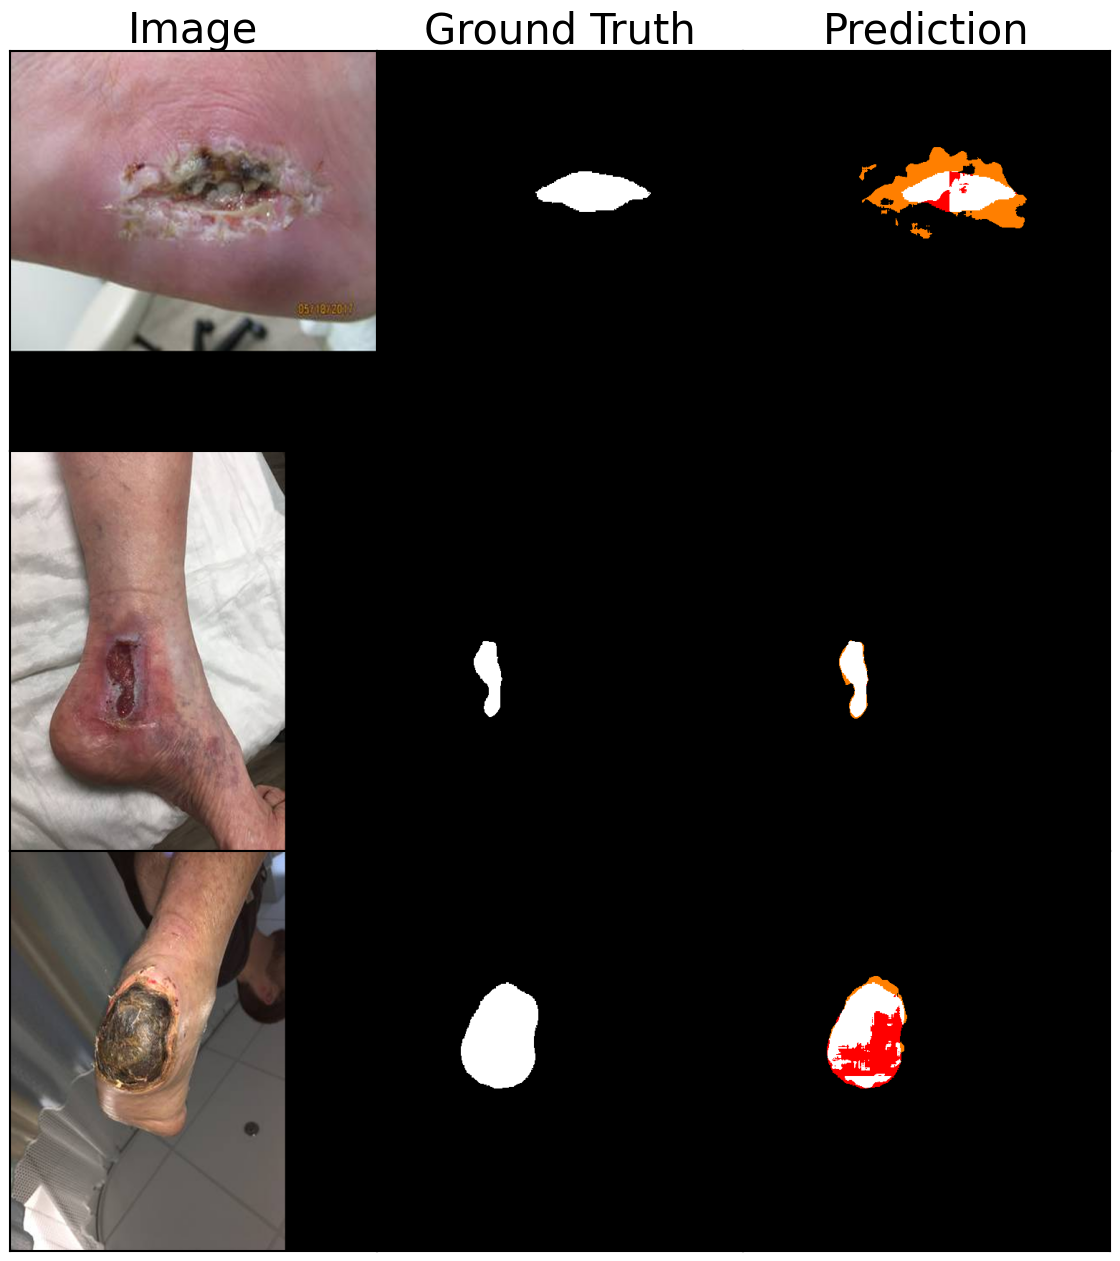

In [16]:
icg = ImageComparisonGenerator(model)
icg.save_output_row(val_loader, samples=[0,1,2], do_diff=True, invert_diff_colors=True)

## Generating images for the paper

In [53]:
#best model for 256 and 128
rpn_model_256_128 = MiniULite(in_channels=3, out_channels=1)
rpn_model_256_128 = load_model(rpn_model_256_128, f'{result_path}MiniULite-focal_loss-epochs300-best.pth')

#best model for 384 64 and 48
rpn_model_384_64_48 = MiniULite(in_channels=3, out_channels=1)
rpn_model_384_64_48 = load_model(rpn_model_384_64_48, f'{result_path}MiniULite-weighted_bin_cross_entropy-epochs300-best.pth')

#Baseline Attention U-Net
atten_unet_inp512 = MiniAttU_Net_5Layers(img_ch=in_channels, output_ch=1)
atten_unet_inp512 = load_model(atten_unet_inp512, f'{colab_result_path}MiniAttU_Net_5Layers-FuSeg-res512-input512-best.pth')

In [54]:
pipeline_384 = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model_384_64_48, robust_model=model_384, patch_dim=384)
pipeline_256 = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model_256_128,   robust_model=model_256, patch_dim=256)
pipeline_128 = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model_256_128,   robust_model=model_128, patch_dim=128)
pipeline_64  = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model_384_64_48, robust_model=model_64,  patch_dim=64)
pipeline_48  = Pipeline(in_channels=3, out_channels=1, rpn_model=rpn_model_384_64_48, robust_model=model_48,  patch_dim=48)

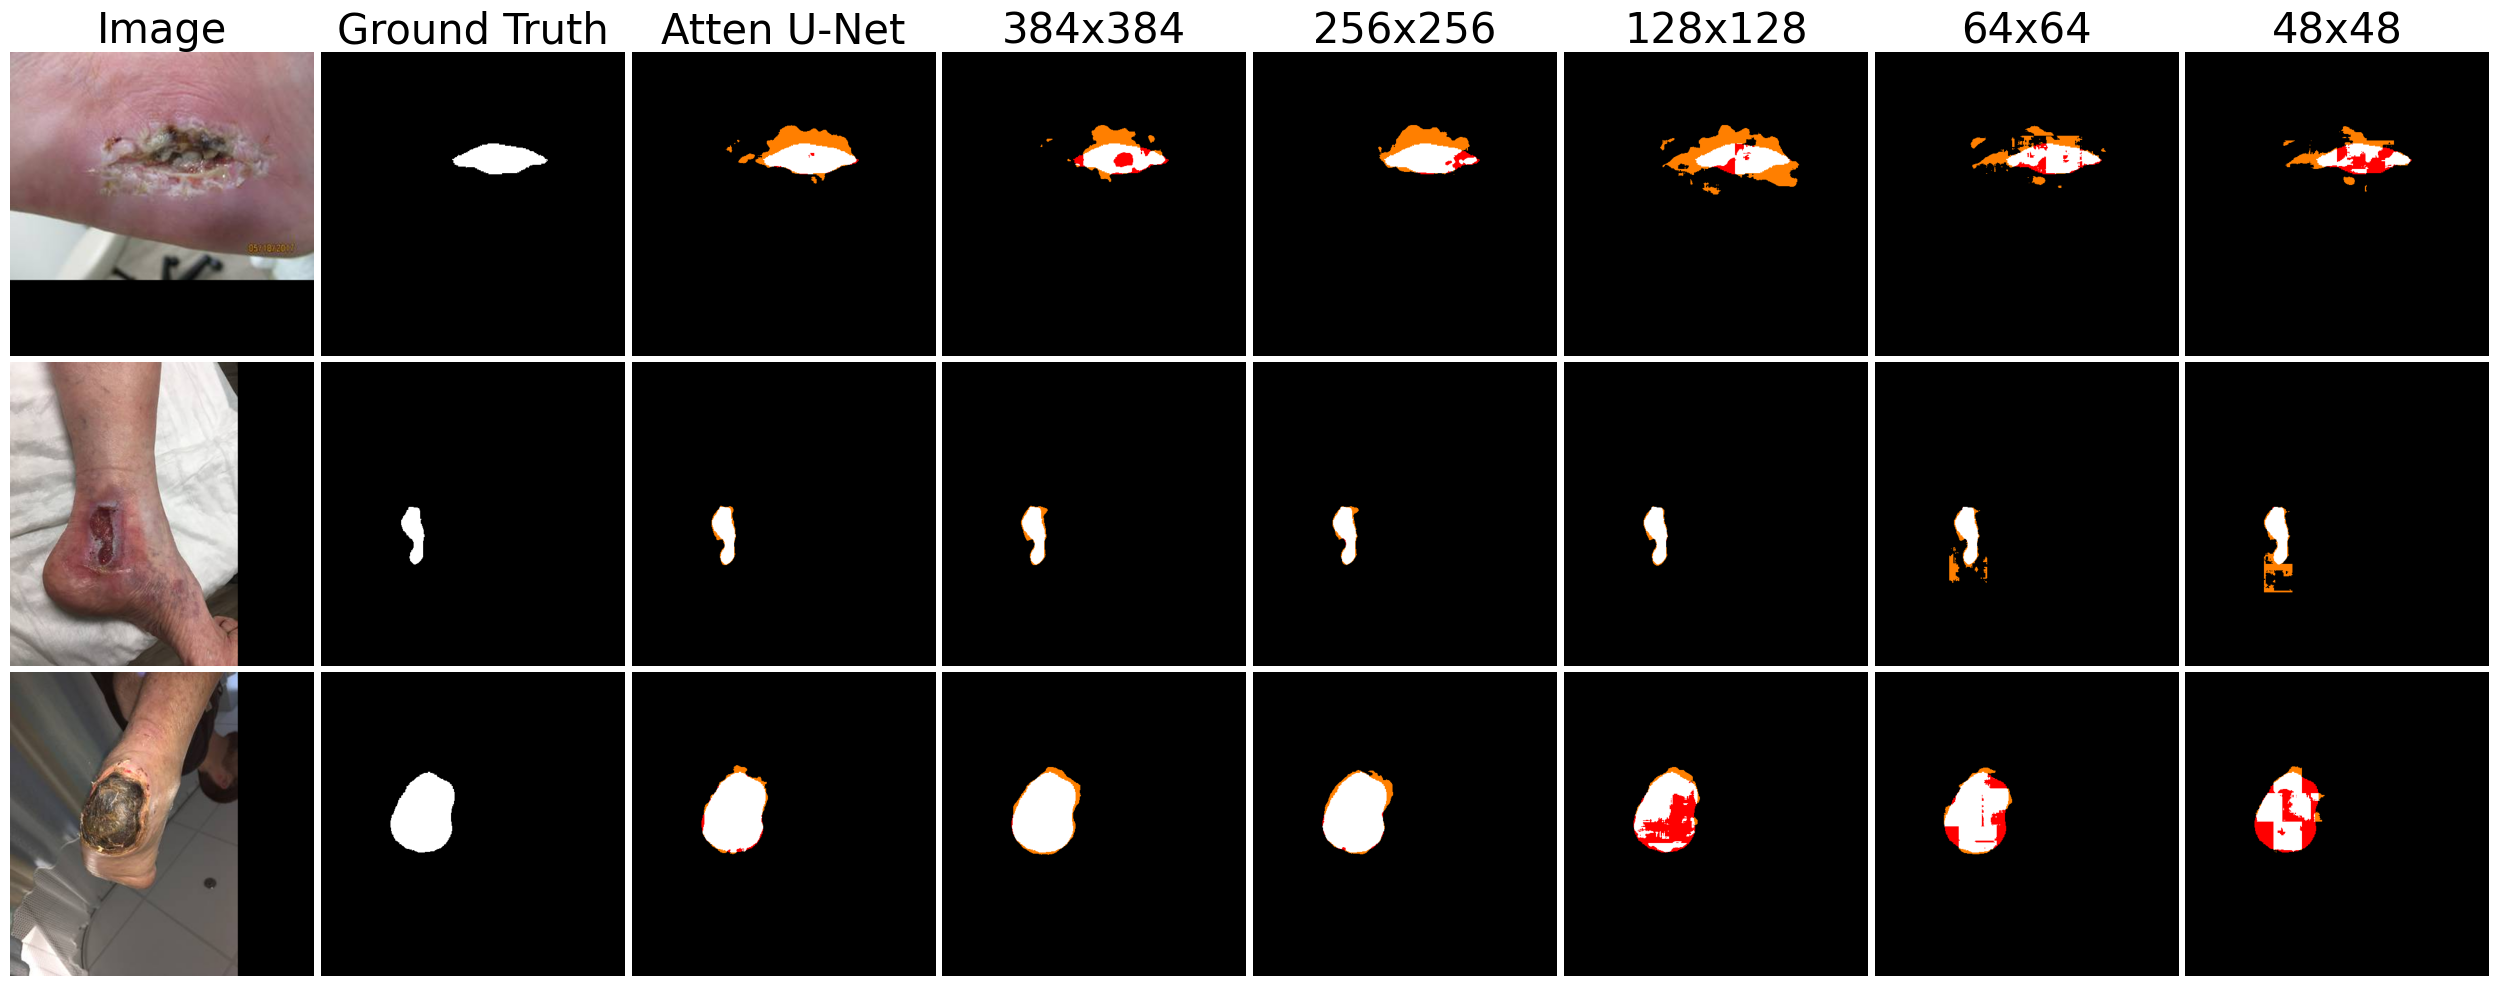

In [55]:
icg = ImageComparisonGenerator(model)


models = [atten_unet_inp512, pipeline_384, pipeline_256, pipeline_128, pipeline_64, pipeline_48]
names = ["Atten U-Net","384x384", "256x256", "128x128", "64x64", "48x48"]
icg.compare_multiple_models_on_val(val_loader, models=models, model_names=names, num_classes=1, samples=[0,1,2], print_as_grid=True, font_size=30, save_as='results.eps')

## Baseline Attention UNet 512x512 - evaluation

In [17]:
from MiniAttenUNet import *

model = MiniAttU_Net_5Layers(img_ch=in_channels, output_ch=1)
model = load_model(model, f'./{colab_result_path}/MiniAttU_Net_5Layers-FuSeg-res512-input512-best.pth')

model.to('cuda')
evaluate_model(model, test_loader, num_classes=2, print_stats=True)

gpu_fps, gpu_t, cpu_fps, cpu_t = measure_inference_speed(model, test_loader)
print("GPU FPS:",gpu_fps, " GPU time:", gpu_t )
print("CPU FPS:",cpu_fps, " CPU time:", cpu_t )

Loss: 0.0000 F1: 0.9583 mIoU: 0.9238 Prec: 0.9602 Recall: 0.9569 Q: 0.8858
GPU FPS: 76.88564227120663  GPU time: 13.006 ms
CPU FPS: 0.544816741645387  CPU time: 1835.480 ms


### Exporting to ONNX

In [57]:
import torch

model.to('cpu')

dummy_input = torch.randn(1, 3, 512, 512)
torch.onnx.export(
    model,
    dummy_input,
    "atten_unet_inp512.onnx",
    export_params=True,
    opset_version=17,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
)

/tmp/ipykernel_17671/3778329120.py:6: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


## Mobile tests

To test on the smartphone, move the onnx to./onnxruntime-inference-benchmark/android/app/src/main/res/raw
Open the ./onnxruntime-inference-benchmark/android project in Android Studio
Make the necessary configuration for each test and run it on a smartphone